In [3]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import dill as pickle

from IPython.display import clear_output

import dali.core as D
from dali.data import Lines, DiscoverFiles, BatchBenefactor
from dali.data.batch import TranslationBatch
from dali.data.translation import TranslationFiles, TranslationMapper, build_vocabs, iterate_examples

from dali.utils import (
    Vocab,
    median_smoothing,
    subsample,
    throttled,
    pickle_globals,
    unpickle_globals,
)
from dali import beam_search

%matplotlib inline

In [5]:
D.config.default_device = 'gpu'

# Data loading

In [6]:
# dataset
DATASET_PATH = "/home/sidor/datasets/translation/"
FROM_LANG = "pl"
TO_LANG   = "en"
FROM_VOCAB_SIZE = 20000
TO_VOCAB_SIZE   = 20000

# batching
MINIBATCH = 128
SENTENCE_LENGTH_BOUNDS = (None, 25)

# network sizes
INPUT_SIZE = 512
HIDDENS = [512, 512, 512, 512]
SOFTMAX_INPUT = None

In [7]:
# you can press stop at any time if you think enough samples were collected.
vocabs = build_vocabs(DATASET_PATH, FROM_LANG, TO_LANG, from_max_size=FROM_VOCAB_SIZE, to_max_size=TO_VOCAB_SIZE)
print (FROM_LANG + "vocabulary containts", len(vocabs[0]), "words")
print (TO_LANG   + "vocabulary containts", len(vocabs[1]), "words")

Impatient User Detected, file processing halted, proceeding to build vocab.
plvocabulary containts 20002 words
envocabulary containts 20002 words


In [9]:
def create_dataset_iterator():
    return iterate_examples(DATASET_PATH, FROM_LANG, TO_LANG, vocabs, 
                            minibatch_size=MINIBATCH,
                            sentence_length_bounds=SENTENCE_LENGTH_BOUNDS)

# Model definition 

In [10]:
class TranslationModel(object):
    def __init__(self, input_size, hiddens, 
                       encoder_vocab_size, decoder_vocab_size,
                       softmax_input_size=None, dtype=np.float32):
        self.input_size = input_size
        self.hiddens    = hiddens
        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size
        self.softmax_input_size = softmax_input_size
        self.dtype = dtype
        
        self.encoder_embedding = D.random.uniform(-0.05, 0.05, (encoder_vocab_size, input_size), dtype=dtype)
        self.decoder_embedding = D.random.uniform(-0.05, 0.05, (decoder_vocab_size, input_size), dtype=dtype)
        
        self.encoder_lstm    = D.StackedLSTM(input_size, hiddens, dtype=dtype)
        self.decoder_lstm    = D.StackedLSTM(input_size, hiddens, dtype=dtype)
        
        if self.softmax_input_size is not None:
            self.predecoder = D.Layer(self.hiddens[-1], self.softmax_input_size)
            self.decoder = D.Layer(self.softmax_input_size, decoder_vocab_size, dtype=dtype)
        else:    
            self.decoder = D.Layer(hiddens[-1], decoder_vocab_size, dtype=dtype)
    
    def decode_state(self, state):
        if self.softmax_input_size is not None:
            decoder_input = self.predecoder.activate(state[-1].hidden)
        else:
            decoder_input = state[-1].hidden
        return self.decoder.activate(decoder_input)
        
    def error(self, batch):
        error = D.Mat(1,1)
        state = self.encoder_lstm.initial_states()
        for ts in range(batch.timesteps):
            inputs  = batch.inputs(ts)
            targets = batch.targets(ts)
            if ts < batch.from_timesteps:
                assert targets is None
                encoded = self.encoder_embedding[inputs]
                state = self.encoder_lstm.activate(encoded, state)
            else:
                assert inputs is None
                decoded = self.decode_state(state)
                # mask the error - only for the relevant sentences
                tstep_error = batch.masks(ts).T() * D.MatOps.softmax_cross_entropy(decoded, targets)
                error = error + tstep_error.sum()
                # feedback the predictions
                if ts +1 != batch.timesteps:
                    # for the last timestep encoding is not necessary
                    encoded = self.decoder_embedding[targets]
                    state = self.decoder_lstm.activate(encoded, state)

        return error
    
    def sample(self, input_sentence, temperature=1.0, **kwargs):
        with D.NoBackprop():
            state = self.encoder_lstm.initial_states()
            for word_idx in input_sentence:
                encoded = self.encoder_embedding[word_idx]
                state = self.encoder_lstm.activate(encoded, state)
            def candidate_scores(state):
                decoded = self.decode_state(state)
                return D.MatOps.softmax(decoded, temperature=temperature).log()
            def make_choice(state, candidate_idx):
                encoded = self.decoder_embedding[candidate_idx]
                return self.decoder_lstm.activate(encoded, state)

            return beam_search(state,
                               candidate_scores,
                               make_choice,
                               **kwargs)
    
    def parameters(self):
        ret = ([self.encoder_embedding,
               self.decoder_embedding]      
            + self.encoder_lstm.parameters() 
            + self.decoder_lstm.parameters() 
            + self.decoder.parameters())
        if self.softmax_input_size is not None:
            ret.extend(self.predecoder.parameters())
        return ret

In [11]:
def show_reconstructions(model, words, temperature=1.0):
    from_vocab, to_vocab = vocabs
    priming = ' '.join(from_vocab.decode(from_vocab.encode(words)))
    print('TRANSLATING: %s' % priming)

    for solution, score, _ in model.sample(from_vocab.encode(words, True), 
                                           eos_symbol=to_vocab.eos,
                                           max_sequence_length=SENTENCE_LENGTH_BOUNDS[1],
                                           blacklist=[], #to_vocab.unk],
                                           temperature=temperature):
        score = math.exp(score.w[0])
        # reveal the unks
        solution = ' '.join(to_vocab.decode(solution, False))
        print('    %f => %s' % (score, to_vocab.decode(solution, True)))

# Create new experiment 

In [12]:
model  = TranslationModel(INPUT_SIZE, HIDDENS, len(vocabs[0]), len(vocabs[1]), softmax_input_size=SOFTMAX_INPUT)

In [13]:
params = model.parameters()
solver = D.SGD(params)
solver.step_size = 0.7

In [14]:
data            = []
error_evolution = []
epoch_error     = []

# (Optional) continue running previous attempt 

In [9]:
unpickle_globals("/home/sidor/tmp/translation_experiment")
params = model.parameters()

# Training

In [15]:
total_error = 0.0
total_time  = 0.0
num_words, num_targets, num_batches = 0, 0, 0

@throttled(5)
def report(example):
    if num_batches == 0 or num_words == 0 or abs(total_time) < 1e-6:
        return
    clear_output()
    print('Error:             ', total_error / num_targets)
    print('Time per batch:    ', total_time  / num_batches)
    print('Words per second:  ', num_words   / total_time )
    print('Batches processed: ', num_batches)
    show_reconstructions(model, example)
    sys.stdout.flush()
    

batch_end_time, batch_start_time = None, None

while True:
    for batch in data:    
        from_sentence = random.choice(batch.sentence_pairs)[0]
        report(from_sentence) 
            
        batch_start_time = time.time()
        error = model.error(batch)

        error.grad()
        D.Graph.backward()
        solver.step(params)
        batch_end_time = time.time()

        epoch_error.append(error.w[0,0] / batch.to_tokens)
        
        total_error   += error.w[0, 0]
        total_time += batch_end_time - batch_start_time

        num_words   += batch.from_tokens + batch.to_tokens
        num_targets += batch.from_tokens + batch.to_tokens
        num_batches    += 1

        # free memory as soon as possible
        del batch
    
    if len(epoch_error) > 0:
        epoch_error = median_smoothing(epoch_error, window=len(epoch_error) / 100)
        epoch_error = subsample(epoch_error, maximum_length=1000)
        epoch_error = []

        error_evolution.append(epoch_error)
    
    data = create_dataset_iterator()

Error:              7.67680861964
Time per batch:     0.7815548583080895
Words per second:   2826.9288796731566
Batches processed:  190
TRANSLATING: Mam dla ciebie ważne zadanie .
    0.720099 => That people the fine fine fine fine fine his his his fine fine fine fine fine fine fine fine fine his his his his his his his
    0.223076 => That people the fine fine fine fine fine fine his his fine fine fine fine fine fine fine fine fine his his his his his his his
    0.043245 => That people the fine fine fine fine fine his his fine fine fine fine fine fine fine fine fine fine his his his his his his his
    0.013397 => That people the fine fine fine fine fine fine his fine fine fine fine fine fine fine fine fine fine his his his his his his his
    0.000087 => That people the fine fine fine fine his his his his fine fine fine fine fine fine fine fine fine his his his his his his his


KeyboardInterrupt: 

In [24]:
pickle_globals("/home/sidor/tmp/translation_experiment", ["model", "solver", "data", "error_evolution"])

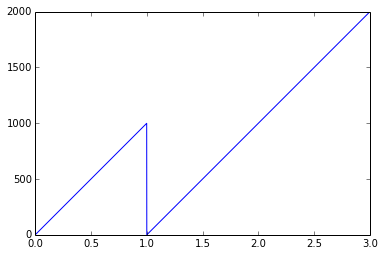

In [12]:
def flatten_error():
    y = []
    for error_epoch in error_evolution:
        y.extend(error_epoch)
    x = [float(t) / 1000.0 for t in range(len(y))]
    return x,y
    
plt.plot(*flatten_error())

['Gdzie', 'ja', 'jestem', '?']